In [1]:
import tensorflow as tf
from tensorflow import reshape
from tensorflow.keras import datasets, layers, models, metrics, Model
from tensorflow.keras.callbacks import Callback
#from data import load_image_h5
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import h5py
#import datetime
print(tf.__version__)

2.0.0


In [2]:
hf = h5py.File('real-attpc-events.h5', 'r')

In [3]:
image_width, image_length, image_channels = 128, 128, 3
image_shape = (128,128,3)

In [4]:
data = hf['features']
label = hf['targets']

In [5]:
data.shape

(2689, 128, 128)

In [6]:
train_data = data[0:2151]
test_data = data[2151:2689]
train_label = label[0:2151]
test_label = label[2151:2689]

In [7]:
from numpy import expand_dims
train_data=expand_dims(train_data, axis=3)
train_data.shape

(2151, 128, 128, 1)

In [8]:
train_data = np.concatenate((train_data,)*3, axis=-1)
train_data.shape

(2151, 128, 128, 3)

In [9]:
test_data=expand_dims(test_data, axis=3)
test_data.shape

(538, 128, 128, 1)

In [10]:
test_data=np.concatenate((test_data,)*3, axis=-1)
test_data.shape

(538, 128, 128, 3)

In [11]:
train_data = train_data.reshape((len(train_data), image_width, image_length, image_channels))

In [12]:
train_data = train_data/255.0
test_data = test_data/255.0

In [13]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [14]:
vgg19_model = tf.keras.applications.VGG19(input_shape=image_shape, include_top=False, weights='imagenet')

In [15]:
vgg19_model.trainable=True

In [16]:
CNN_model = tf.keras.Sequential()
CNN_model.add(vgg19_model)
CNN_model.add(layers.Flatten())
CNN_model.add(layers.Dense(150, activation='relu'))
CNN_model.add(layers.Dropout(0.6))
CNN_model.add(layers.Dense(150, activation='relu'))
CNN_model.add(layers.Dropout(0.6))
CNN_model.add(layers.Dense(3, activation='softmax'))

CNN_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                 metrics=['accuracy'])

In [17]:
CNN_history = CNN_model.fit(train_data, train_label, epochs=80,
                           batch_size=32,
                           shuffle=True,
                           callbacks = [callback],
                           validation_split=0.3)

Train on 1505 samples, validate on 646 samples
Epoch 1/80
1505/1505 [==============================] - 10s 7ms/sample - loss: 1.4686 - accuracy: 0.3096 - val_loss: 0.9907 - val_accuracy: 0.5975
Epoch 2/80
1505/1505 [==============================] - 4s 3ms/sample - loss: 1.1940 - accuracy: 0.4279 - val_loss: 0.8860 - val_accuracy: 0.6161
Epoch 3/80
1505/1505 [==============================] - 4s 3ms/sample - loss: 1.1689 - accuracy: 0.4591 - val_loss: 0.8500 - val_accuracy: 0.6409
Epoch 4/80
1505/1505 [==============================] - 4s 3ms/sample - loss: 1.0665 - accuracy: 0.5043 - val_loss: 0.8267 - val_accuracy: 0.6594
Epoch 5/80
1505/1505 [==============================] - 4s 3ms/sample - loss: 0.9716 - accuracy: 0.5694 - val_loss: 0.7967 - val_accuracy: 0.6842
Epoch 6/80
1505/1505 [==============================] - 4s 3ms/sample - loss: 0.9783 - accuracy: 0.5561 - val_loss: 0.7681 - val_accuracy: 0.7307
Epoch 7/80
1505/1505 [==============================] - 4s 3ms/sample - loss

1505/1505 [==============================] - 5s 3ms/sample - loss: 0.4143 - accuracy: 0.8332 - val_loss: 0.3535 - val_accuracy: 0.8715
Epoch 54/80
1505/1505 [==============================] - 5s 3ms/sample - loss: 0.4024 - accuracy: 0.8538 - val_loss: 0.3499 - val_accuracy: 0.8700
Epoch 55/80
1505/1505 [==============================] - 5s 3ms/sample - loss: 0.4206 - accuracy: 0.8551 - val_loss: 0.3546 - val_accuracy: 0.8731
Epoch 56/80
1505/1505 [==============================] - 5s 3ms/sample - loss: 0.3922 - accuracy: 0.8505 - val_loss: 0.3525 - val_accuracy: 0.8746
Epoch 57/80
1505/1505 [==============================] - 5s 3ms/sample - loss: 0.3891 - accuracy: 0.8518 - val_loss: 0.3532 - val_accuracy: 0.8715
Epoch 58/80
1505/1505 [==============================] - 5s 3ms/sample - loss: 0.3865 - accuracy: 0.8598 - val_loss: 0.3556 - val_accuracy: 0.8684
Epoch 59/80
1505/1505 [==============================] - 5s 3ms/sample - loss: 0.3873 - accuracy: 0.8625 - val_loss: 0.3547 - val_

In [18]:
result = CNN_model.evaluate(test_data, test_label, verbose=2)

538/1 - 1s - loss: 0.3037 - accuracy: 0.8792


In [19]:
predictions = np.argmax(CNN_model.predict(test_data[:]),axis=1)

In [20]:
print(classification_report(test_label, predictions))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       128
           1       0.55      0.63      0.59        57
           2       0.92      0.90      0.91       353

    accuracy                           0.88       538
   macro avg       0.80      0.82      0.81       538
weighted avg       0.88      0.88      0.88       538



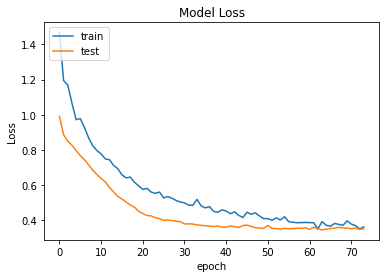

In [21]:
plt.plot(CNN_history.history['loss'])
plt.plot(CNN_history.history['val_loss'])
plt.title('Model Loss')
#plt.yscale("log")
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import itertools

In [23]:
cm = confusion_matrix(test_label, predictions)

In [24]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         include_values=True,
                         cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

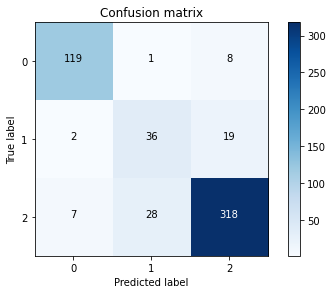

In [25]:
cm_plot_labels = ['0', '1', '2']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion matrix')